In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc

from sklearn.utils import resample

import warnings

In [2]:
ariq = pd.read_csv('comments - ariq.csv')
fadel = pd.read_csv('comments - fadel.csv')
kemas = pd.read_csv('comments - kemas.csv')

In [3]:
# combine all df
df = pd.concat([ariq, fadel, kemas])
df

,author,updated_at,like_count,text,video_id,public,"(1: positif, 0: negatif, 2: netral)"
0,@asanjayaparamisi4515,2024-05-21T14:54:30Z,0,Hanya wasitlah yg bisa menghentikan lajunya ke...,i7V5sI7gVAw,True,0.0
1,@akhmalahmad,2024-05-21T06:02:13Z,0,Wasit❌,i7V5sI7gVAw,True,0.0
2,@user-tx5zu9zm2n,2024-05-20T18:35:31Z,0,Wasit nya ..culik....buang ke laut......cari ....,i7V5sI7gVAw,True,0.0
3,@Arkana-mq3kx,2024-05-20T09:42:11Z,0,Arham guooooblox,i7V5sI7gVAw,True,0.0
4,@BaxtiyorOtajonov-hl1eb,2024-05-19T10:32:52Z,0,Uzbekistan Halal❤,i7V5sI7gVAw,True,1.0
...,...,...,...,...,...,...,...
995,@Arifinilman,2024-04-27T13:56:37Z,0,Merinding cuy pas anthem Indonesia raya 🥺,tAqzxb6VCqs,True,1.0
996,@vickopermana5367,2024-04-27T13:54:26Z,0,Ningggalin jejak❤,tAqzxb6VCqs,True,2.0
997,@Indonesia.903,2024-04-27T13:54:19Z,0,Ini adalah pertandingan real Madrid cabang ase...,tAqzxb6VCqs,True,1.0
998,@Jloramadan,2024-04-27T13:53:45Z,0,🇮🇩❤️,tAqzxb6VCqs,True,1.0


In [4]:
# change column name
df.rename(columns={'(1: positif, 0: negatif, 2: netral)': 'Sentiment'}, inplace=True)

In [5]:
# drop row if Sentiment is NaN
df.dropna(subset=['Sentiment'], inplace=True)

In [6]:
df

,author,updated_at,like_count,text,video_id,public,Sentiment
0,@asanjayaparamisi4515,2024-05-21T14:54:30Z,0,Hanya wasitlah yg bisa menghentikan lajunya ke...,i7V5sI7gVAw,True,0.0
1,@akhmalahmad,2024-05-21T06:02:13Z,0,Wasit❌,i7V5sI7gVAw,True,0.0
2,@user-tx5zu9zm2n,2024-05-20T18:35:31Z,0,Wasit nya ..culik....buang ke laut......cari ....,i7V5sI7gVAw,True,0.0
3,@Arkana-mq3kx,2024-05-20T09:42:11Z,0,Arham guooooblox,i7V5sI7gVAw,True,0.0
4,@BaxtiyorOtajonov-hl1eb,2024-05-19T10:32:52Z,0,Uzbekistan Halal❤,i7V5sI7gVAw,True,1.0
...,...,...,...,...,...,...,...
995,@Arifinilman,2024-04-27T13:56:37Z,0,Merinding cuy pas anthem Indonesia raya 🥺,tAqzxb6VCqs,True,1.0
996,@vickopermana5367,2024-04-27T13:54:26Z,0,Ningggalin jejak❤,tAqzxb6VCqs,True,2.0
997,@Indonesia.903,2024-04-27T13:54:19Z,0,Ini adalah pertandingan real Madrid cabang ase...,tAqzxb6VCqs,True,1.0
998,@Jloramadan,2024-04-27T13:53:45Z,0,🇮🇩❤️,tAqzxb6VCqs,True,1.0


In [7]:
df['Sentiment'].value_counts()

1.0    901
0.0    595
2.0    292
Name: Sentiment, dtype: int64

In [8]:
# cleaning text
import re
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'RT[\s]+', '', text) # remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlink
    text = re.sub(r'\n', '', text) # remove newline
    return text

In [9]:
# using clean_text function on text column
df['text'] = df['text'].apply(clean_text)

In [10]:
df

,author,updated_at,like_count,text,video_id,public,Sentiment
0,@asanjayaparamisi4515,2024-05-21T14:54:30Z,0,Hanya wasitlah yg bisa menghentikan lajunya ke...,i7V5sI7gVAw,True,0.0
1,@akhmalahmad,2024-05-21T06:02:13Z,0,Wasit❌,i7V5sI7gVAw,True,0.0
2,@user-tx5zu9zm2n,2024-05-20T18:35:31Z,0,Wasit nya ..culik....buang ke laut......cari ....,i7V5sI7gVAw,True,0.0
3,@Arkana-mq3kx,2024-05-20T09:42:11Z,0,Arham guooooblox,i7V5sI7gVAw,True,0.0
4,@BaxtiyorOtajonov-hl1eb,2024-05-19T10:32:52Z,0,Uzbekistan Halal❤,i7V5sI7gVAw,True,1.0
...,...,...,...,...,...,...,...
995,@Arifinilman,2024-04-27T13:56:37Z,0,Merinding cuy pas anthem Indonesia raya 🥺,tAqzxb6VCqs,True,1.0
996,@vickopermana5367,2024-04-27T13:54:26Z,0,Ningggalin jejak❤,tAqzxb6VCqs,True,2.0
997,@Indonesia.903,2024-04-27T13:54:19Z,0,Ini adalah pertandingan real Madrid cabang ase...,tAqzxb6VCqs,True,1.0
998,@Jloramadan,2024-04-27T13:53:45Z,0,🇮🇩❤️,tAqzxb6VCqs,True,1.0


In [11]:
# delete emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [12]:
# apply remove_emoji function on text column
df['text'] = df['text'].apply(remove_emoji)

In [13]:
df

,author,updated_at,like_count,text,video_id,public,Sentiment
0,@asanjayaparamisi4515,2024-05-21T14:54:30Z,0,Hanya wasitlah yg bisa menghentikan lajunya ke...,i7V5sI7gVAw,True,0.0
1,@akhmalahmad,2024-05-21T06:02:13Z,0,Wasit,i7V5sI7gVAw,True,0.0
2,@user-tx5zu9zm2n,2024-05-20T18:35:31Z,0,Wasit nya ..culik....buang ke laut......cari ....,i7V5sI7gVAw,True,0.0
3,@Arkana-mq3kx,2024-05-20T09:42:11Z,0,Arham guooooblox,i7V5sI7gVAw,True,0.0
4,@BaxtiyorOtajonov-hl1eb,2024-05-19T10:32:52Z,0,Uzbekistan Halal,i7V5sI7gVAw,True,1.0
...,...,...,...,...,...,...,...
995,@Arifinilman,2024-04-27T13:56:37Z,0,Merinding cuy pas anthem Indonesia raya 🥺,tAqzxb6VCqs,True,1.0
996,@vickopermana5367,2024-04-27T13:54:26Z,0,Ningggalin jejak,tAqzxb6VCqs,True,2.0
997,@Indonesia.903,2024-04-27T13:54:19Z,0,Ini adalah pertandingan real Madrid cabang ase...,tAqzxb6VCqs,True,1.0
998,@Jloramadan,2024-04-27T13:53:45Z,0,,tAqzxb6VCqs,True,1.0


In [14]:
# make new column POS if Sentiment is 1, NEG if Sentiment is 0, NEUT if Sentiment is 2
df['POS'] = np.where(df['Sentiment'] == 1, 1, 0)
df['NEG'] = np.where(df['Sentiment'] == 0, 1, 0)
df['NEUT'] = np.where(df['Sentiment'] == 2, 1, 0)

In [15]:
df

,author,updated_at,like_count,text,video_id,public,Sentiment,POS,NEG,NEUT
0,@asanjayaparamisi4515,2024-05-21T14:54:30Z,0,Hanya wasitlah yg bisa menghentikan lajunya ke...,i7V5sI7gVAw,True,0.0,0,1,0
1,@akhmalahmad,2024-05-21T06:02:13Z,0,Wasit,i7V5sI7gVAw,True,0.0,0,1,0
2,@user-tx5zu9zm2n,2024-05-20T18:35:31Z,0,Wasit nya ..culik....buang ke laut......cari ....,i7V5sI7gVAw,True,0.0,0,1,0
3,@Arkana-mq3kx,2024-05-20T09:42:11Z,0,Arham guooooblox,i7V5sI7gVAw,True,0.0,0,1,0
4,@BaxtiyorOtajonov-hl1eb,2024-05-19T10:32:52Z,0,Uzbekistan Halal,i7V5sI7gVAw,True,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
995,@Arifinilman,2024-04-27T13:56:37Z,0,Merinding cuy pas anthem Indonesia raya 🥺,tAqzxb6VCqs,True,1.0,1,0,0
996,@vickopermana5367,2024-04-27T13:54:26Z,0,Ningggalin jejak,tAqzxb6VCqs,True,2.0,0,0,1
997,@Indonesia.903,2024-04-27T13:54:19Z,0,Ini adalah pertandingan real Madrid cabang ase...,tAqzxb6VCqs,True,1.0,1,0,0
998,@Jloramadan,2024-04-27T13:53:45Z,0,,tAqzxb6VCqs,True,1.0,1,0,0


In [16]:
# change column dtype to int
df['POS'] = df['POS'].astype(int)
df['NEG'] = df['NEG'].astype(int)
df['NEUT'] = df['NEUT'].astype(int)

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state = 23)
train

,author,updated_at,like_count,text,video_id,public,Sentiment,POS,NEG,NEUT
524,@abigerry27,2024-05-01T08:50:43Z,69,Keputusan wasit yg sulit diterima karena merug...,i7V5sI7gVAw,True,1.0,1,0,0
528,@roykane8211,2024-04-27T19:52:24Z,0,Lagu Indonesia raya sungguh menyentuh hati,tAqzxb6VCqs,True,1.0,1,0,0
468,@user-te7uu4qr2u,2024-05-01T11:40:49Z,0,,i7V5sI7gVAw,True,1.0,1,0,0
544,@AlasKobar953,2024-04-25T21:17:04Z,1,JANTUNG BERASA BERGOYANG SENDIRI SEPANJANG AD...,tAqzxb6VCqs,True,1.0,1,0,0
450,@sifcreator6642,2024-05-01T12:24:00Z,2,"wasitnya gk se imbang banyak Kecurangan,. Tolo...",i7V5sI7gVAw,True,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
408,@fredi_clear,2024-04-28T01:00:08Z,0,Gw senengnya indonesia ga terlalu ngotot buat ...,tAqzxb6VCqs,True,1.0,1,0,0
123,@sumarni4358,2024-04-27T12:39:28Z,0,Tim begadang sampai subuh dan abis subuh tetap...,tAqzxb6VCqs,True,1.0,1,0,0
421,@mancingbersamajojovlogmanc1243,2024-04-25T22:27:20Z,0,GACORRR,tAqzxb6VCqs,True,1.0,1,0,0
828,@NiraxitaliliksoeharjonosohailB,2024-05-08T12:19:21Z,0,The head coach is shin tae yong,tAqzxb6VCqs,True,2.0,0,0,1


In [18]:
list_classes = ['POS','NEUT','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["text"]
list_sentences_test = test["text"]

In [19]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

[[510,
  2,
  8,
  1163,
  1786,
  90,
  453,
  1,
  715,
  56,
  1164,
  511,
  358,
  10,
  58,
  19,
  359,
  261,
  5,
  231,
  173,
  186]]

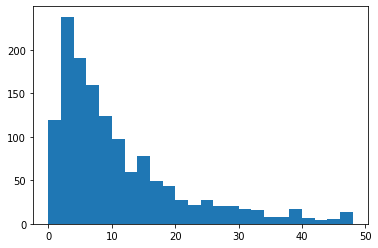

In [20]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,50,2))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [21]:
def loadEmbeddingMatrix(typeToLoad):
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [22]:
def create_fold_embeddings(embeddings_dim, key_vector, tokenizer):
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
        elif word in key_vector:
            emb_init_values.append(key_vector[word])
            b += 1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a += 1
            unk.append(word)

    known_word = b
    unknown_word = a

    print(f"Known words: {known_word}, Unknown words: {unknown_word}")

    return known_word, unknown_word, emb_init_values

In [23]:


#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model300.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [24]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors, tokenizer)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

Known words: 3306, Unknown words: 959
known words: 3306
unknown words: 959


In [25]:
print(emb_init_values)

[[ 1.1840802e-01  2.1516044e-01  1.2098496e+00 ... -2.3446472e+00
   9.2748529e-01 -2.6964734e+00]
 [ 1.3022171e+00 -3.1239000e-01 -1.0846971e+00 ... -1.4256744e+00
  -2.9936039e-01 -9.5939475e-01]
 [-2.4397199e+00  2.2610443e+00 -1.1884675e+00 ...  8.2900667e-01
  -4.0545598e-01 -1.0253814e+00]
 ...
 [-1.3335520e-01  1.9426653e-01 -1.0095533e-01 ...  1.3880546e-01
   1.9409434e-01 -8.2809210e-02]
 [ 1.8777026e-01  1.5719125e-01 -7.4148795e-04 ... -1.8687966e-01
   2.1243644e-01 -9.2299223e-02]
 [-5.1513767e-01  1.0221822e+00  7.2301042e-01 ...  1.9993679e-01
  -3.2209456e-02  4.5413584e-01]]


In [26]:
emb_init_values.shape

(4265, 300)

In [27]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [28]:
inp = Input(shape=(maxlen,))

In [29]:
x = Embedding(len(tokenizer.word_index), emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = Bidirectional(LSTM(64, activation='tanh', return_sequences = True, dropout=0.4))(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(32)(x)
x = Dropout(0.1)(x)
x = Dense(16)(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

Epoch 1/100


c:\Users\fadel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



 ROC-AUC - epoch: 1 - score: 0.612781 

45/45 - 11s - loss: 1.1068 - accuracy: 0.4343 - val_loss: 1.0085 - val_accuracy: 0.4888 - 11s/epoch - 236ms/step
Epoch 2/100

 ROC-AUC - epoch: 2 - score: 0.650737 

45/45 - 1s - loss: 1.0260 - accuracy: 0.4986 - val_loss: 0.9997 - val_accuracy: 0.4832 - 934ms/epoch - 21ms/step
Epoch 3/100

 ROC-AUC - epoch: 3 - score: 0.653412 

45/45 - 1s - loss: 1.0170 - accuracy: 0.5119 - val_loss: 0.9932 - val_accuracy: 0.5000 - 856ms/epoch - 19ms/step
Epoch 4/100

 ROC-AUC - epoch: 4 - score: 0.661733 

45/45 - 1s - loss: 0.9914 - accuracy: 0.5189 - val_loss: 0.9916 - val_accuracy: 0.4944 - 889ms/epoch - 20ms/step
Epoch 5/100

 ROC-AUC - epoch: 5 - score: 0.672424 

45/45 - 1s - loss: 0.9941 - accuracy: 0.5273 - val_loss: 0.9731 - val_accuracy: 0.5112 - 866ms/epoch - 19ms/step
Epoch 6/100

 ROC-AUC - epoch: 6 - score: 0.682629 

45/45 - 1s - loss: 0.9757 - accuracy: 0.5364 - val_loss: 0.9624 - val_accuracy: 0.5391 - 869ms/epoch - 19ms/step
Epoch 7/100

 RO

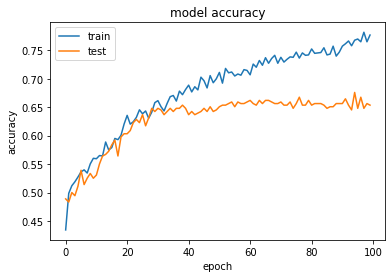

In [30]:
# plot accuracy train and validation
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           1279500   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          186880    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [33]:
from keras.models import load_model
c = model.predict(X_te)
c

12/12 [==============================] - 0s 12ms/step


array([[8.8651136e-02, 4.1677386e-02, 8.6967152e-01],
       [7.4930154e-03, 3.5064798e-02, 9.5744222e-01],
       [9.5861566e-01, 3.5459176e-02, 5.9251897e-03],
       ...,
       [9.8855186e-01, 1.0700624e-02, 7.4751501e-04],
       [5.3547319e-02, 6.6192895e-02, 8.8025975e-01],
       [2.8656664e-01, 1.8463691e-01, 5.2879643e-01]], dtype=float32)

In [34]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 15ms/step - loss: 0.8615 - accuracy: 0.6536
Test accuracy: 0.6536312699317932


In [35]:
print(model.metrics_names)

['loss', 'accuracy']


In [36]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

 5/12 [===========>..................] - ETA: 0s

12/12 [==============================] - 0s 12ms/step


0.8235153822512276

In [37]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

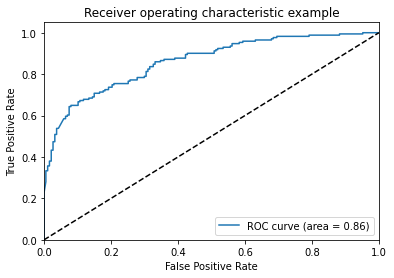

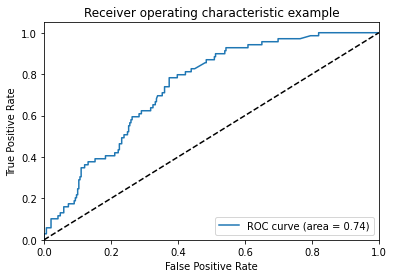

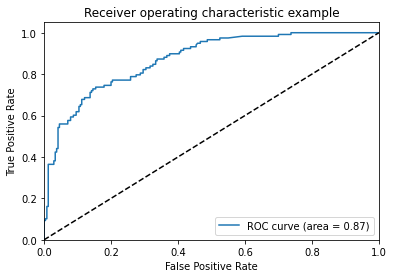

In [38]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
roc_auc_score(y_te, y_pred)

0.8235153822512276

In [40]:
y_te

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [41]:
y_pred

array([[8.8651136e-02, 4.1677386e-02, 8.6967152e-01],
       [7.4930154e-03, 3.5064798e-02, 9.5744222e-01],
       [9.5861566e-01, 3.5459176e-02, 5.9251897e-03],
       ...,
       [9.8855186e-01, 1.0700624e-02, 7.4751501e-04],
       [5.3547319e-02, 6.6192895e-02, 8.8025975e-01],
       [2.8656664e-01, 1.8463691e-01, 5.2879643e-01]], dtype=float32)

In [42]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
y_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)

In [43]:
y_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)

In [44]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[ 82 105]
  [ 11 160]]

 [[257  32]
  [ 45  24]]

 [[199  41]
  [ 31  87]]]
              precision    recall  f1-score   support

           0       0.60      0.94      0.73       171
           1       0.43      0.35      0.38        69
           2       0.68      0.74      0.71       118

   micro avg       0.60      0.76      0.67       358
   macro avg       0.57      0.67      0.61       358
weighted avg       0.60      0.76      0.66       358
 samples avg       0.66      0.76      0.69       358



In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)) 

array([[160,   2,   9],
       [ 57,   3,   9],
       [ 48,   2,  68]], dtype=int64)

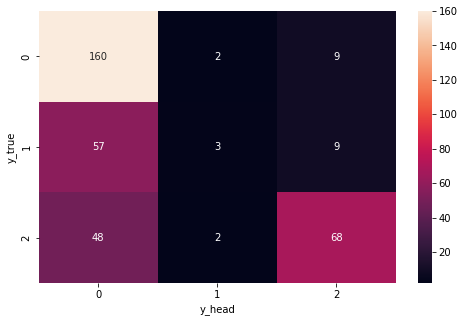

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()